In [83]:
from PIL import Image
import os
import random
import torch
from torch.utils.data  import Dataset, DataLoader
from torchvision import transforms,models
to_tensor = transforms.ToTensor()
to_img = transforms.ToPILImage()
tsfm = transforms.Compose([transforms.RandomHorizontalFlip(),
                           transforms.RandomVerticalFlip(),
                           transforms.RandomAffine((-30,30))])
USE_CUDA = torch.cuda.is_available()

In [84]:
from unet import UNet

In [273]:
def resize_img(img,max_width = 400):
    w,h = img.size
    max_height = int(h / w * max_width)
    img = img.resize((max_width,max_height),Image.ANTIALIAS)
    return img

def get_random_pos(big_box,small_box):
    bw,bh = big_box
    sw,sh = small_box
    x = random.randrange(0,bw-sw)
    y = random.randrange(0,bh-sh)
    return(x,y)

class myDataset(Dataset):
    def __init__(self, n = 10,path_org = '../data/src', path_wm = '../data/watermarks',path_out = "data/out",tsfm = None,gen=False):
        super().__init__()
        self.n = n
        self.path_org = path_org
        self.path_wm = path_wm
        self.path_out = path_out
        self.gen = gen
        self.imglist= [os.path.join(path_org,x) for x in os.listdir(self.path_org) if x.endswith('.jpg')]
        self.imglist_size = len(self.imglist)
        self.wmlist = [os.path.join(path_wm,x) for x in os.listdir(self.path_wm) if x.endswith('.png')]
        self.wmlist_size = len(self.wmlist)
        
    def __len__(self):
        return self.n
       
    def __getitem__(self,idx):
        ix = random.randrange(0,self.imglist_size)
        iwm = random.randrange(0,self.wmlist_size)

        img = Image.open(self.imglist[ix]).convert("RGB")
        img = resize_img(img)
        imgwm = Image.open(self.wmlist[iwm])
        #imgwm = imgwm if imgwm.size[0] <150 else resize_img(imgwm,random.randrange(100,190))
        if tsfm: imgwm = tsfm(imgwm)
        imgwm = resize_img(imgwm,random.randrange(150,200))
        imgwm = imgwm.convert("RGBA")
        r,g,b,a = imgwm.split()

        x,y = get_random_pos(img.size,(200,200))
        img = img.crop((x,y,x+200,y+200))

        target = Image.new("RGBA",(200,200),(0,0,0,0))
        target.paste(img,(0,0))

        x,y = get_random_pos((200,200),imgwm.size)
        target.paste(imgwm,(x,y),a)
        target = target.convert("RGB")

        if self.gen:
            target.save(os.path.join(self.path_out,str(idx) + ".png"))
            out =  {"src":img, "wm":target}
        else:
            src_t = to_tensor(img)
            wm_t = to_tensor(target)
            out = {"src_t":src_t, "wm_t":wm_t}
        return out

In [274]:
train_ds  = myDataset(n = 1000,tsfm = tsfm)
train_dl =DataLoader(train_ds,batch_size=5)

In [89]:

model = UNet(3,3)
optim = torch.optim.RMSprop(model.parameters(),lr=1e-4)

In [90]:
vgg = models.vgg16(pretrained=True)
vgg.eval()
for p in vgg.parameters():
    p.required_grad=False
#if USE_CUDA:vgg.cuda()
    
def vgg_layer(x,n=4):
    for i in range(n):
        x = vgg.features[i].cuda()(x)
    return x

In [91]:
L1_Loss= torch.nn.L1Loss()
MSE_Loss = torch.nn.MSELoss()
def loss_func(x,y):
    d = torch.abs(x - y)
    d = d /(0.3+y)
    return torch.mean(d)
def loss_func_vgg(x,y):
    return MSE_Loss(vgg_layer(x),vgg_layer(y))

In [376]:
if USE_CUDA :model.cuda()
model.train()
for i,x in enumerate(train_dl):
    src_t = x['src_t']
    wm_t = x['wm_t']
    if  USE_CUDA:
        src_t = src_t.cuda()
        wm_t = wm_t.cuda()
    out = model(wm_t)
    loss = loss_func_vgg(out,src_t)
   
    optim.zero_grad()
    loss.backward()
    optim.step()
    if i % 10 ==9:
         print(f"{i},loss={loss.data}")

9,loss=0.0035495946649461985
19,loss=0.0027715195901691914
29,loss=0.0027816076762974262
39,loss=0.007887867279350758
49,loss=0.0033366309944540262
59,loss=0.0031814775429666042
69,loss=0.0017678564181551337
79,loss=0.0029273051768541336
89,loss=0.003559933975338936
99,loss=0.0033377069048583508
109,loss=0.003477010177448392
119,loss=0.0038693754468113184
129,loss=0.0026439251378178596
139,loss=0.0040600975044071674
149,loss=0.0029669373761862516
159,loss=0.0028737932443618774
169,loss=0.004537172149866819
179,loss=0.004265851341187954
189,loss=0.002520163543522358
199,loss=0.0027717079501599073


In [378]:
torch.save(model,'unet_d323.pkl')

C:\Users\blazex\.conda\envs\fastai\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type UNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\blazex\.conda\envs\fastai\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type DoubleConv. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\blazex\.conda\envs\fastai\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\blazex\.conda\envs\fastai\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name

# end

In [375]:
optim.param_groups[0]['lr'] =1e-6

In [ ]:
#xx = myDataset(n=10,gen=True)

In [379]:
model.cpu()
model.eval()

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, moment

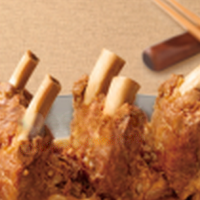

In [381]:
to_img(model(train_ds[0]['wm_t'].unsqueeze(0)).squeeze(0))

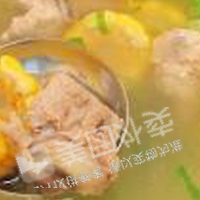

In [382]:
to_img(train_ds[0]['wm_t'])

# 

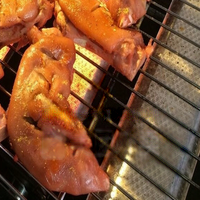

In [403]:
x =Image.open("../meituan/20.jpg").resize((400,400),Image.ANTIALIAS).crop((200,200,400,400))
to_img(model(to_tensor(x).unsqueeze(0)).squeeze(0))

In [ ]:
to_img(vgg_layer(train_ds[0]['wm_t'].unsqueeze(0).cuda()).cpu()[0,6])

In [ ]:
model.cpu()

In [9]:
from fastai.vision import get_image_files
ele = get_image_files('../../ele_food_pic/ele_food_pic/',recurse=True)
train_ds.imglist = ele
train_ds.imglist_size = len(ele)